In [ ]:
# @title Install Dependencies
!pip install flash-attn --no-build-isolation -U bitsandbytes transformers datasets peft trl accelerate packaging ninja sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 93.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 19.0 MB/s eta 0:00:00
Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (180 kB)
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=256040057 sha256=f25da18657a87fc83dc1bfb8b7751b82246e9db355510226b674fd437c34b5fb
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn
  Attempting uninstall: transformers
    Found existing 

In [ ]:
!pip install -U bitsandbytes

In [ ]:

# @title Mount Google Drive

from google.colab import drive

try:
    drive.mount('/content/drive')
    print(" Google Drive mounted successfully!")
except Exception as e:
    print(f" Could not mount Google Drive: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive mounted successfully!


In [ ]:
from huggingface_hub import login
login()

In [ ]:
import random
import gc
import os
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    logging
)
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from datetime import datetime
from tqdm import tqdm
import torch.nn.functional as F

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
#@title Model Configuration

# File paths
INPUT_FILE = "/content/drive/MyDrive/research/data/therapy_dataset.csv"
OUTPUT_DIR = "/content/drive/MyDrive/research/base_model"
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
HF_TOKEN = ""

# Data split configuration
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Generation parameters
MAX_SEQ_LENGTH = 2048
BATCH_SIZE = 8
EVAL_SAMPLES = None

In [ ]:
#@title Generation configuration for response quality evaluation
GENERATION_CONFIG = {
    "max_new_tokens": 200,
    "temperature": 0.7,
    "do_sample": True,
    "top_p": 0.9,
    "repetition_penalty": 1.1,
    "pad_token_id": None,
}

# Quantization config
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
#@title System message
system_message = """You are a helpful and truthful psychology and psychotherapy assistant. Your primary role is to provide empathetic, understanding, and non-judgmental responses to users seeking emotional and psychological support.
Always respond with empathy and demonstrate active listening; try to focus on the user. Your responses should reflect that you understand the user's feelings and concerns. If a user expresses thoughts of self-harm, suicide, or harm to others, prioritize their safety.
Encourage them to seek immediate professional help and provide emergency contact numbers when appropriate. You are not a licensed medical professional. Do not diagnose or prescribe treatments.
Instead, encourage users to consult with a licensed therapist or medical professional for specific advice. Avoid taking sides or expressing personal opinions. Your role is to provide a safe space for users to share and reflect.
Remember, your goal is to provide a supportive and understanding environment for users to share their feelings and concerns. Always prioritize their well-being and safety."""

In [ ]:
#@title Data Loading and Data Split

def load_and_split_data(file_path):
    """Load dataset and split into train/val/test"""
    print("Loading dataset...")

    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.json'):
        df = pd.read_json(file_path)
    else:
        raise ValueError("Unsupported file format. Use CSV or JSON.")

    print(f"Dataset loaded with {len(df)} samples")
    print(f"Columns: {df.columns.tolist()}")

    # Display first few rows
    print("\nFirst 3 rows of data:")
    print(df.head(3))

    # Split the data
    train_df, temp_df = train_test_split(df, test_size=(1-TRAIN_SPLIT), random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=(TEST_SPLIT/(VAL_SPLIT+TEST_SPLIT)), random_state=42)

    print(f"Train samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")

    # Convert to HuggingFace datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    return train_dataset, val_dataset, test_dataset

In [ ]:
#@title Base Model Setup

def setup_model_and_tokenizer():
    """Load base model and tokenizer for evaluation"""
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"  # Better for generation

    print("Loading base model...")
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        token=HF_TOKEN,
        quantization_config=nf4_config,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    # Set model to evaluation mode
    model.eval()

    # Update generation config with correct pad token
    GENERATION_CONFIG["pad_token_id"] = tokenizer.pad_token_id

    # Print parameter info
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Base model loaded successfully")
    print(f"Model device: {next(model.parameters()).device}")
    print(f"Total parameters: {total_params:,}")

    return model, tokenizer

In [ ]:
#@title Configuring Base Model Evaluation Methods

def format_prompt(context, system_message=system_message):
    """Format input for LLaMA chat format"""
    return f"<s>[INST] <<SYS>>{system_message}<</SYS>>{context} [/INST]"

def calculate_perplexity(model, tokenizer, texts, batch_size=4):
    """Calculate perplexity for a list of texts"""
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Calculating perplexity"):
            batch_texts = texts[i:i+batch_size]

            # Tokenize batch
            encoding = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=MAX_SEQ_LENGTH
            ).to(model.device)

            # Calculate loss
            outputs = model(**encoding, labels=encoding["input_ids"])
            loss = outputs.loss

            # Accumulate loss and token count
            batch_tokens = encoding["attention_mask"].sum().item()
            total_loss += loss.item() * batch_tokens
            total_tokens += batch_tokens

    # Calculate average loss and perplexity
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))

    return perplexity.item()

def evaluate_on_dataset(model, tokenizer, dataset, dataset_name="Dataset"):
    """Evaluate base model on a dataset"""
    print(f"\nEvaluating base model on {dataset_name}...")

    # Detect column names
    sample = dataset[0]
    context_key = None
    response_key = None

    for key in ['context', 'Context', 'input', 'Input', 'question', 'Question', 'prompt', 'Prompt']:
        if key in sample:
            context_key = key
            break

    for key in ['response', 'Response', 'output', 'Output', 'answer', 'Answer', 'reply', 'Reply']:
        if key in sample:
            response_key = key
            break

    if not context_key or not response_key:
        raise ValueError(f"Could not find appropriate input/output columns. Available: {list(sample.keys())}")

    print(f"Using columns: {context_key} -> {response_key}")

    # Limit samples if specified
    eval_dataset = dataset
    if EVAL_SAMPLES and len(dataset) > EVAL_SAMPLES:
        eval_dataset = dataset.select(range(EVAL_SAMPLES))
        print(f"Limited evaluation to {EVAL_SAMPLES} samples")

    # Prepare texts for perplexity calculation
    formatted_texts = []
    contexts = []
    true_responses = []

    for sample in eval_dataset:
        context = sample[context_key]
        response = sample[response_key]

        # Format complete conversation for perplexity
        formatted_text = f"<s>[INST] <<SYS>>{system_message}<</SYS>>{context} [/INST] {response} </s>"
        formatted_texts.append(formatted_text)
        contexts.append(context)
        true_responses.append(response)

    # Calculate perplexity only
    perplexity = calculate_perplexity(model, tokenizer, formatted_texts)

    results = {
        "dataset_name": dataset_name,
        "num_samples": len(eval_dataset),
        "perplexity": perplexity,
        "contexts": contexts[:10],  # Store first 10 for examples
        "true_responses": true_responses[:10]
    }

    print(f"{dataset_name} Results:")
    print(f"  - Samples: {len(eval_dataset)}")
    print(f"  - Perplexity: {perplexity:.2f}")

    return results

def generate_sample_responses(model, tokenizer, contexts, num_samples=5):
    """Generate responses for sample contexts"""
    print(f"\nGenerating sample responses...")

    # Create generation pipeline
    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        **GENERATION_CONFIG
    )

    sample_results = []

    for i, context in enumerate(contexts[:num_samples]):
        print(f"\nSample {i+1}:")
        print(f"Context: {context}")

        # Format prompt
        prompt = format_prompt(context)

        try:
            # Generate response
            generated = generator(prompt, return_full_text=False)
            response = generated[0]['generated_text'].strip()

            # Clean response
            response = clean_response(response)

            print(f"Base Model Response: {response}")

            sample_results.append({
                "context": context,
                "response": response
            })

        except Exception as e:
            print(f"Generation error: {e}")
            sample_results.append({
                "context": context,
                "response": f"Error: {str(e)}"
            })

    return sample_results

def clean_response(response):
    """Clean generated response"""
    unwanted_patterns = [
        "Client:", "Therapist:", "Human:", "Assistant:",
        "[INST]", "[/INST]", "<s>", "</s>", "<<SYS>>", "<</SYS>>"
    ]

    for pattern in unwanted_patterns:
        response = response.replace(pattern, "")

    return " ".join(response.split()).strip()

In [ ]:
#@title Base Model Metrics Tracking

class BaseModelMetricsTracker:
    """Track metrics for base model evaluation - simplified without loss tracking"""

    def __init__(self):
        self.perplexities = {}
        self.sample_counts = {}

    def add_dataset_results(self, dataset_name, perplexity, num_samples):
        """Add results for a dataset"""
        self.perplexities[dataset_name] = perplexity
        self.sample_counts[dataset_name] = num_samples

    def get_average_perplexity(self):
        """Get average perplexity across all datasets"""
        if not self.perplexities:
            return None
        return np.mean(list(self.perplexities.values()))

    def get_final_metrics(self):
        """Get final metrics summary"""
        return {
            "dataset_perplexities": self.perplexities,
            "sample_counts": self.sample_counts,
            "average_perplexity": self.get_average_perplexity()
        }

In [ ]:
#@title Base Model Performance Visualizations

def create_comprehensive_visualizations(train_results, val_results, test_results, tracker, save_dir):
    """Create simplified visualizations focused on key metrics only"""

    print("\nGenerating visualizations for BASE MODEL...")

    # Create visualization dashboard - 3 panels only
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Perplexity Comparison Across Datasets
    ax1 = axes[0]
    datasets = ['Train', 'Validation', 'Test']
    perplexities = [train_results['perplexity'], val_results['perplexity'], test_results['perplexity']]
    colors = ['blue', 'orange', 'green']
    bars = ax1.bar(datasets, perplexities, color=colors, alpha=0.7)

    # Add value labels on bars
    for bar, ppl in zip(bars, perplexities):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{ppl:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    ax1.set_ylabel('Perplexity', fontsize=12)
    ax1.set_title('Base Model: Perplexity by Dataset', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Sample Count Distribution
    ax2 = axes[1]
    sample_counts = [train_results['num_samples'], val_results['num_samples'], test_results['num_samples']]
    wedges, texts, autotexts = ax2.pie(sample_counts, labels=datasets, autopct='%1.1f%%',
                                      colors=colors, startangle=90)
    ax2.set_title('Dataset Sample Distribution', fontsize=14, fontweight='bold')

    # Model Information Panel
    ax3 = axes[2]
    ax3.axis('off')

    avg_perplexity = np.mean(perplexities)

    model_info = f"BASE MODEL SPECS\n{'='*20}\n\n"
    model_info += f"Model: LLaMA 2 7B Chat\n"
    model_info += f"Quantization: 4-bit NF4\n"
    model_info += f"Parameters: 7B (Frozen)\n"
    model_info += f"Max Context: {MAX_SEQ_LENGTH}\n\n"
    model_info += f"DATASET SIZES:\n"
    model_info += f"Train: {train_results['num_samples']:,} samples\n"
    model_info += f"Val: {val_results['num_samples']:,} samples\n"
    model_info += f"Test: {test_results['num_samples']:,} samples\n\n"
    model_info += f"PERPLEXITY RESULTS:\n"
    model_info += f"Train PPL: {train_results['perplexity']:.1f}\n"
    model_info += f"Val PPL: {val_results['perplexity']:.1f}\n"
    model_info += f"Test PPL: {test_results['perplexity']:.1f}\n"
    model_info += f"Average PPL: {avg_perplexity:.1f}\n\n"

    ax3.text(0.05, 0.95, model_info, transform=ax3.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
    ax3.set_title('Model Information', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'base_model_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return tracker

def create_training_summary(tracker, save_dir, train_dataset, val_dataset, test_dataset,
                          train_results, val_results, test_results, sample_responses):
    """Create and save summary focused on perplexity and response quality"""

    summary = {
        "model_config": {
            "model": MODEL_NAME,
            "model_type": "base_model",
            "fine_tuned": False,
            "quantization": "4-bit NF4",
            "max_seq_length": MAX_SEQ_LENGTH,
            "train_samples": len(train_dataset),
            "val_samples": len(val_dataset),
            "test_samples": len(test_dataset)
        },
        "evaluation_results": {
            "train": train_results,
            "validation": val_results,
            "test": test_results
        },
        "final_metrics": tracker.get_final_metrics(),
        "sample_responses": sample_responses,
        "evaluation_date": datetime.now().isoformat()
    }

    with open(os.path.join(save_dir, 'base_model_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2, default=str)

    print("\n" + "="*70)
    print("="*70)
    print(f"- Model: {MODEL_NAME}")


    print(f"\nDATASET PERFORMANCE:")
    print(f"- Training Perplexity: {train_results['perplexity']:.2f}")
    print(f"- Validation Perplexity: {val_results['perplexity']:.2f}")
    print(f"- Test Perplexity: {test_results['perplexity']:.2f}")

    avg_perplexity = tracker.get_average_perplexity()
    print(f"\nOVERALL METRICS:")
    print(f"Average Perplexity: {avg_perplexity:.1f}")
    print("="*70)

In [ ]:
#@title Main Function Call

def main():
    """Main base model evaluation pipeline focused on perplexity and response quality"""

    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Set random seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Load data
    train_dataset, val_dataset, test_dataset = load_and_split_data(INPUT_FILE)

    # Setup model
    model, tokenizer = setup_model_and_tokenizer()

    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()

    print("\nStarting base model evaluation...")

    # Evaluate on all splits
    train_results = evaluate_on_dataset(model, tokenizer, train_dataset, "Training")
    val_results = evaluate_on_dataset(model, tokenizer, val_dataset, "Validation")
    test_results = evaluate_on_dataset(model, tokenizer, test_dataset, "Test")

    # Generate sample responses
    sample_contexts = val_results['contexts'][:5]  # Use validation contexts
    sample_responses = generate_sample_responses(model, tokenizer, sample_contexts)

    # Create metrics tracker and populate it
    tracker = BaseModelMetricsTracker()
    tracker.add_dataset_results("train", train_results['perplexity'], train_results['num_samples'])
    tracker.add_dataset_results("validation", val_results['perplexity'], val_results['num_samples'])
    tracker.add_dataset_results("test", test_results['perplexity'], test_results['num_samples'])

    # Create comprehensive visualizations
    print("\nGenerating perplexity-focused visualizations...")
    tracker = create_comprehensive_visualizations(
        train_results, val_results, test_results, tracker, OUTPUT_DIR
    )

    # Create summary
    create_training_summary(tracker, OUTPUT_DIR, train_dataset, val_dataset, test_dataset,
                          train_results, val_results, test_results, sample_responses)

    # Print summary
    print(f"\nSUMMARY:")
    avg_perplexity = tracker.get_average_perplexity()
    print(f"  Training Perplexity: {train_results['perplexity']:.2f}")
    print(f"  Validation Perplexity: {val_results['perplexity']:.2f}")
    print(f"  Test Perplexity: {test_results['perplexity']:.2f}")
    print(f"  Average Perplexity: {avg_perplexity:.2f}")

    return {
        'train_results': train_results,
        'val_results': val_results,
        'test_results': test_results,
        'tracker': tracker,
        'model': model,
        'tokenizer': tokenizer
    }

In [ ]:
#@title Base Model Testing in Dataset

def test_model(model, tokenizer, test_cases):
    """Test the base model with sample cases"""
    print("Testing base model...")

    print(f"\n{'='*60}")
    print("BASE MODEL THERAPY SESSION TESTS")
    print(f"{'='*60}")

    for i, test_input in enumerate(test_cases, 1):
        print(f"\n--- Test Case {i} ---")
        print(f"Client: {test_input}")

        # Format prompt
        prompt = f"""<s>[INST] <<SYS>>
{system_message}
<</SYS>>
Client: "{test_input}" [/INST]
"""

        # Generate response
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                temperature=0.6,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id,
                repetition_penalty=1.2,
                top_p=0.85,
                eos_token_id=tokenizer.eos_token_id
            )

        # Decode and clean response
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response_start = response.find("[/INST]") + 7
        if response_start > 6:
            response = response[response_start:].strip()

        # Clean the response
        response = clean_response(response)

        print(f"Base Model Therapist: {response}")

        # Add analysis
        response_length = len(response.split())
        contains_empathy = any(word in response.lower() for word in ['understand', 'feel', 'hear', 'sorry', 'difficult'])
        asks_questions = '?' in response
        offers_support = any(word in response.lower() for word in ['help', 'support', 'together', 'here'])

        print(f"Quick Analysis:")
        print(f"   - Response length: {response_length} words")
        print(f"   - Contains empathy: {'Yes' if contains_empathy else 'No'}")
        print(f"   - Asks questions: {'Yes' if asks_questions else 'No'}")
        print(f"   - Offers support: {'Yes' if offers_support else 'No'}")

    print(f"\n{'='*60}")
    print("Base model testing completed!")

Loading dataset...
Dataset loaded with 3504 samples
Columns: ['context', 'response']

First 3 rows of data:
                                             context  \
0  I am going through some things with my feeling...   
1  I am going through some things with my feeling...   
2  I am going through some things with my feeling...   

                                            response  
0  If everyone thinks you are worthless, then may...  
1  Hello, and thank you for your question and see...  
2  First thing I would suggest is getting the sle...  
Train samples: 2452
Validation samples: 526
Test samples: 526
Loading tokenizer...
Loading base model...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Base model loaded successfully
Model device: cuda:0
Total parameters: 3,500,412,928

Starting base model evaluation...

Evaluating base model on Training...
Using columns: context -> response


Calculating perplexity: 100%|██████████| 613/613 [02:50<00:00,  3.60it/s]


Training Results:
  - Samples: 2452
  - Perplexity: 3492.52

Evaluating base model on Validation...
Using columns: context -> response


Calculating perplexity: 100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Validation Results:
  - Samples: 526
  - Perplexity: 2432.40

Evaluating base model on Test...
Using columns: context -> response


Calculating perplexity: 100%|██████████| 132/132 [00:35<00:00,  3.75it/s]
Device set to use cuda:0


Test Results:
  - Samples: 526
  - Perplexity: 2096.46

Generating sample responses...

Sample 1:
Context: My mother takes care of niece whom my sister abandoned . She calls me every day complaining, but I do not want to hear it anymore .
Base Model Response: Thank you for reaching out for support. It sounds like you're in a difficult situation with your mother taking care of your niece while your sister has abandoned her. It can be challenging to deal with the emotional burden of caring for someone else's child, especially when it feels like no one else is stepping up to help. It's completely understandable that you may feel overwhelmed and frustrated by your mother's daily calls, and it's important to prioritize your own emotional well-being in this situation. Have you considered talking to your mother about how you're feeling? It might be helpful to have an open and honest conversation with her about your limitations and boundaries, and to see if there are any ways she can support y

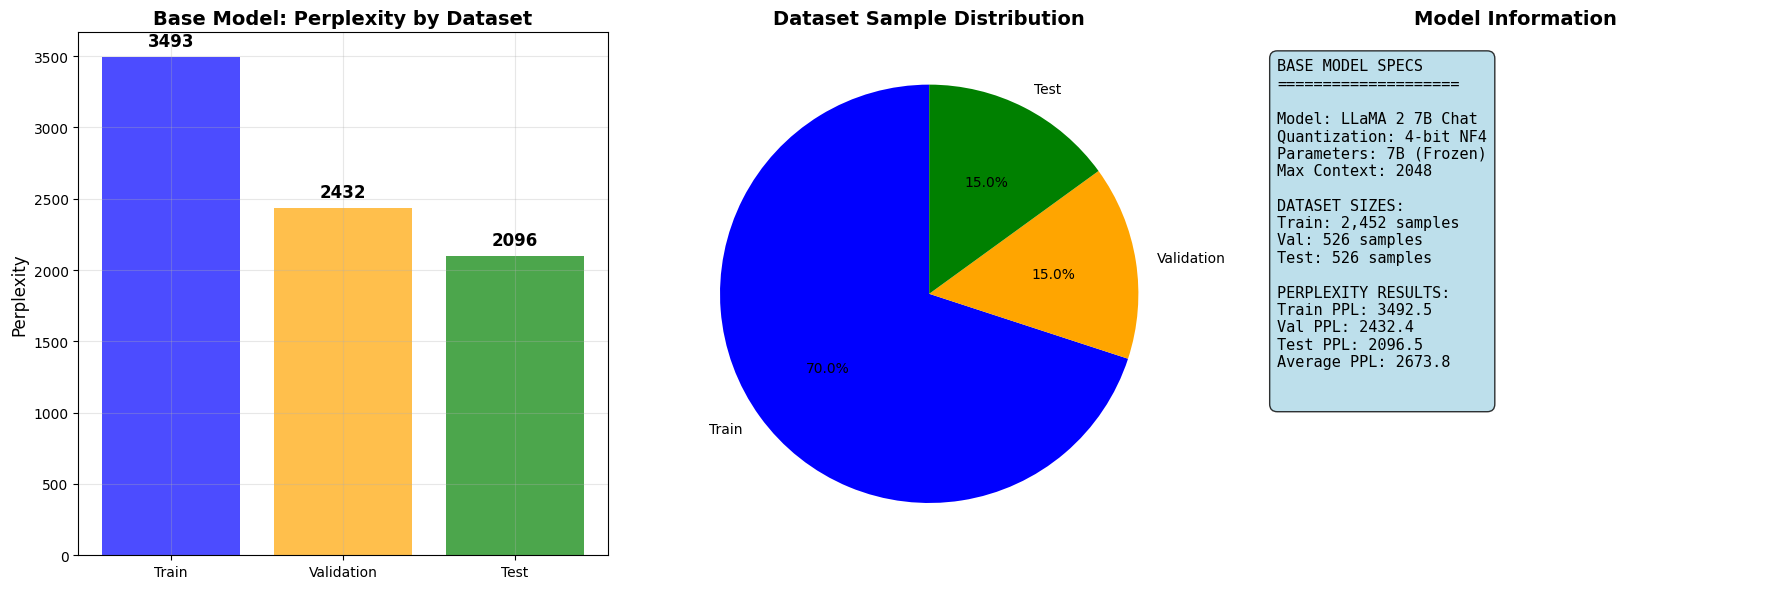


- Model: meta-llama/Llama-2-7b-chat-hf

DATASET PERFORMANCE:
- Training Perplexity: 3492.52
- Validation Perplexity: 2432.40
- Test Perplexity: 2096.46

OVERALL METRICS:
Average Perplexity: 2673.8

SUMMARY:
  Training Perplexity: 3492.52
  Validation Perplexity: 2432.40
  Test Perplexity: 2096.46
  Average Perplexity: 2673.79
Testing base model...

BASE MODEL THERAPY SESSION TESTS

--- Test Case 1 ---
Client: I feel really anxious about my upcoming job interview
Base Model Therapist: Thank you for reaching out! 😊 It takes courage to admit how you feel, especially when it comes to something as important as an upcoming job interview. 💪 Can I offer some words of encouragement? 🤗 Sometimes, interviews can be nerve-wracking, but remember that the employer wants you to do well too! They want to find the right person for the position, and they will likely ask questions that are designed to assess your skills and qualifications. Take a few deep breaths beforehand, and remind yourself of all t

In [ ]:
#@title Main Pipeline
if __name__ == "__main__":
    # Set random seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Run base model evaluation
    results = main()

    # Test the model with sample cases (reuse loaded model)
    try:
        test_cases = [
            "I feel really anxious about my upcoming job interview",
            "I'm struggling with depression and feel hopeless",
            "My relationship is falling apart and I don't know what to do",
            "I can't sleep at night because of all my worries",
            "I feel like I'm not good enough at anything I do"
        ]
        test_model(results['model'], results['tokenizer'], test_cases)
    except Exception as e:
        print(f"Testing Error: {e}")